In [97]:
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt

In [98]:
class CommNet:
    
    def __init__(self, sess, N, J, embedding_size = 128, lr = 1e-3, training_mode = 'supervised', gamma = 1):
        
        self.N = N
        self.J = J
        self.embedding_size = embedding_size
        
        self.build_controler()
        
        self.training_mode = training_mode
        
        if training_mode == 'supervised':
            self.build_supervised()
            with tf.variable_scope('Supervised_optimizer'):
                self.train_op = tf.train.AdamOptimizer(lr).minimize(self.supervised_loss)
                
        elif training_mode == 'reinforce':
            self.gamma = gamma
            self.build_reinforce()
            with tf.variable_scope('Reinforce_optimizer'):
                self.train_op =  tf.train.AdamOptimizer(lr).minimize(self.reinforce_loss)
            
        else:
            raise(ValueError("Unknown training mode: %s" % training_mode))
        
        print("All variables")
        for var in tf.global_variables():
            print(var)
            
        
        self.sess = sess
        self.sess.run(tf.global_variables_initializer())
        
    def encode(self, inputs):
        
        with tf.variable_scope('Encoder'):
        
            identity_embeddings = tf.get_variable("identity_embeddings",
                                             [self.N, self.embedding_size])
            
            embedded_identities = tf.nn.embedding_lookup(identity_embeddings, inputs)
            
        return tf.unstack(embedded_identities, axis = 1)
    
    def build_f(self, name, h, c, h0 = None):
        
        with tf.variable_scope(name, reuse = tf.AUTO_REUSE):
            
            if h0 is not None:
                
                W1 = tf.get_variable('W1', shape = (3 * self.embedding_size,
                                                  self.embedding_size))
                
                concat = tf.concat([h, c, h0], axis = 1)
            
            else:
                W1 = tf.get_variable('W1', shape = (2 * self.embedding_size,
                                                  self.embedding_size))
                
                concat = tf.concat([h, c], axis = 1)
            
            W2 = tf.get_variable('W2', shape = (self.embedding_size,
                                                  self.embedding_size))
            
            dense1 =  tf.nn.relu(tf.einsum("ij,jk->ik", concat, W1))
            dense2 = tf.nn.relu(tf.einsum("ij,jk->ik", dense1, W2))
            
            return dense2
        
    def decode(self, h):
        
        with tf.variable_scope('Decoder', reuse = tf.AUTO_REUSE):
            
            W = tf.get_variable('W', shape = (self.embedding_size,
                                                  self.J))
            
            policy_logit = tf.einsum("ij,jk->ik", h, W)
        
            return policy_logit
    
    
    def communicate(self, h_seq):
        
        return tf.add_n(h_seq) / (self.J - 1)
    
    def sample_actions(self, policy_logit):
        
        
        action = tf.multinomial(policy_logit, num_samples = 1)
        
        return action
    
        
    def build_controler(self):
        
        self.inputs = tf.placeholder(tf.int32, shape = (None, self.J))
        
        h0_seq = self.encode(self.inputs)
        c0_seq = [self.communicate([h0_seq[j] for j in range(self.J) if j != i]) for i in range(self.J)]
        
        h1_seq = [self.build_f("Comm_step_1", h0_seq[j], c0_seq[j], None) for j in range(self.J)]
        c1_seq = [self.communicate([h1_seq[j] for j in range(self.J) if j != i]) for i in range(self.J)]
        
        h2_seq = [self.build_f("Comm_step_2", h1_seq[j], c1_seq[j], h0_seq[j]) for j in range(self.J)]
        
        
        self.policy_logit_seq = [self.decode(h2) for h2 in h2_seq]
        
        self.action_seq = [self.sample_actions(policy_logit) for policy_logit in self.policy_logit_seq]
        
        
        
    def build_supervised(self):
        
        assert self.training_mode == 'supervised', 'Wrong training mode'
        
        self.one_hot_action_seq = [tf.one_hot(tf.reshape(action, [-1]), depth = self.J) for action in self.action_seq]
        self.targets = tf.placeholder(tf.int32, shape = (None, self.J))
        unstacked_targets = tf.unstack(self.targets, axis = 1)
        
        supervised_loss_seq = [tf.nn.sparse_softmax_cross_entropy_with_logits(labels=unstacked_targets[j],
                                                                                   logits=self.policy_logit_seq[j])
                                    for j in range(self.J)]
        
        self.supervised_loss = tf.reduce_sum(tf.add_n(supervised_loss_seq))
        
        
        
    def supervised_train(self, X, y, val_X, val_y, env, batch_size = 32, epochs = 1):
        
        assert self.training_mode == 'supervised', 'Wrong training mode'
        
        n = X.shape[0]
        
        val_n = val_X.shape[0]
        
        data_inds = np.array(range(n))
        for ep in range(1, epochs + 1):
            np.random.shuffle(data_inds)
            supervised_loss_sum = 0
            reward_sum = 0
            for i in tqdm(range(0, n, batch_size), "Epoch: %d" % ep):
                inds_batch = data_inds[i:i+batch_size]
                X_batch = X[inds_batch]
                y_batch = y[inds_batch]
                _, supervised_loss, one_hot_action_seq = sess.run([self.train_op, self.supervised_loss, self.one_hot_action_seq], feed_dict={self.inputs: X_batch, self.targets: y_batch})
                supervised_loss_sum += supervised_loss
                reward_sum += env.get_reward(one_hot_action_seq)
            
            print("loss = %f" % (supervised_loss_sum / n))
            print("reward = %f" % (reward_sum / n))
            print()
            
            val_supervised_loss, val_one_hot_action_seq = sess.run([self.supervised_loss, self.one_hot_action_seq], feed_dict={self.inputs: val_X, self.targets: val_y})
            print('val loss = %f' % (val_supervised_loss / val_n))
            print('val reward = %f' % (env.get_reward(val_one_hot_action_seq) / val_n))
            

    def build_reinforce(self):
        
        assert self.training_mode == 'reinforce', 'Wrong training mode'
        
        self.log_p_seq = [tf.log(tf.nn.softmax(policy_logit, axis = 1)) for policy_logit in self.policy_logit_seq]
        
        self.advantage = tf.placeholder(tf.float32, shape = (None, self.J))
        unstacked_advantage = tf.unstack(self.advantage, axis = 1)
        
        self.action_taken = tf.placeholder(tf.int32, shape = (None, self.J))
        unstacked_action_taken = tf.unstack(self.action_taken, axis = 1)
        
        one_hot_action_taken_seq = [tf.one_hot(unstacked_action_taken[j], depth = self.J, dtype = tf.int32) for j in range(self.J)]
        
        # selecting probabilites corresponding to taken action
        self.action_taken_p_seq = [tf.dynamic_partition(self.log_p_seq[j], one_hot_action_taken_seq[j], num_partitions = 2)[1] for j in range(self.J)]
        
        #surrogate loss
        self.reinforce_loss =  - tf.add_n([tf.reduce_sum(tf.multiply(unstacked_advantage[j], self.action_taken_p_seq[j]), axis = 0) for j in range(self.J)])
        
    def take_action(self, state):
        
        assert self.training_mode == 'reinforce', 'Wrong training mode'
        
        action_seq= self.sess.run(self.action_seq, {self.inputs: [state]})
        
        return [x[0,0] for x in action_seq]
    
    def reinforce_train(self, env, n_episodes, T):
        
        assert self.training_mode == 'reinforce', 'Wrong training mode'
        
        baseline = np.zeros(self.N)
        
        discount_factors = np.array([self.gamma ** t for t in range(T)])
        
        history = []
    
        
        for _ in tqdm(range(n_episodes), "REINFORCE"):
            
            # todo: change code to avoid this seq_seq name (sequence of sequence)
            state_seq, action_seq, reward_seq = policy_rollout(T, env, commNet)
            t = reward_seq.shape[0]
            G = np.sum(reward_seq * discount_factors[:t])
            
            history.append(np.mean(reward_seq))
            
            
            
            feed_dict = {}
            feed_dict[self.inputs] = state_seq
            feed_dict[self.advantage] = G - baseline[state_seq]
            feed_dict[self.action_taken] = action_seq
            
            self.sess.run(self.train_op, feed_dict = feed_dict)
            
            
            # update baseline
            raveled_state_seq = state_seq.ravel()
            repeated_reward_seq = np.repeat(reward_seq, self.J)
            distinct_states = list(set(raveled_state_seq))
            state_count = np.zeros(self.N)
            reward_sum = np.zeros(self.N)
            
            for s,r in zip(raveled_state_seq, repeated_reward_seq):
                state_count[s] += 1
                reward_sum[s] += r
            baseline[distinct_states] = 0.99 * baseline[distinct_states] + 0.01 * reward_sum[distinct_states]/state_count[distinct_states]
        return history
            
            
            
            
            
            
            
        

In [99]:
class LeverEnv:
    
    def __init__(self, N, J):
        
        self.J = J
        self.N = N
        
    def reset(self):
        
        state = np.sort(np.random.choice(self.N, size = self.J, replace = False))
        
        terminal_state = False
        
        return state, terminal_state        
    
    def get_reward(self, one_hot_action_seq):        
        
        reward = np.sum(np.sum(one_hot_action_seq, axis = 0) > 0) /self.J
        
        return reward
        
    def step(self, state, action):
        
        next_state = np.sort(np.random.choice(self.N, size = self.J, replace = False))
        
        one_hot_action_seq = np.zeros((self.J, self.J))
        one_hot_action_seq[range(self.J), action] = 1
        reward = self.get_reward(one_hot_action_seq)
        
        terminal_state = False
        
        return next_state, reward, terminal_state
        

In [100]:
# data generation for supervised learning
def generate_data(n, N, J):
    
    X = np.empty((n, J), dtype = int)
    
    for i in range(n):
        
        X[i] = np.sort(np.random.choice(N, size = J, replace = False))
        
    y = np.tile([j for j in range(J)], (n,1))
        
    return X, y

In [101]:
# episode generation for reinforcement learning
def policy_rollout(T, env, agent):
    
    state_seq = []
    action_seq = []
    reward_seq = []
    
    
    state, terminal_state = env.reset()
    
    t = 0
    
    while not terminal_state and t < T:
        t +=1
        
        state_seq.append(state)
        action = agent.take_action(state)
        
        state, reward, terminal_state = env.step(state, action)
        
        
        action_seq.append(action)
        reward_seq.append(reward)
        
    return np.array(state_seq), np.array(action_seq), np.array(reward_seq)

In [102]:
N = 20
J = 3
batch_size = 32
n = batch_size * 1000

In [70]:
X, y = generate_data(n, N, J)
val_X, val_y = generate_data(1024, N, J)

In [81]:
tf.reset_default_graph()
with tf.Session() as sess:
    commNet = CommNet(sess, N, J, lr = 1e-3, training_mode = 'reinforce')
    env = LeverEnv(N, J)
    #commNet.supervised_train(X, y, val_X, val_y, env, batch_size = batch_size, epochs = 10)
    
    #history = commNet.reinforce_train(env, n_episodes = 1000, T = 3)
    #state_seq, action_seq, reward_seq = policy_rollout(3, env, commNet)
    
    state_seq, action_seq, reward_seq = policy_rollout(3, env, commNet)
    
    print(state_seq)
    print(action_seq)
    print(reward_seq)
    G = np.sum(reward_seq)
    print(G)
    
    feed_dict = {}
    feed_dict[commNet.inputs] = state_seq
    feed_dict[commNet.advantage] = G * np.ones((3, J))
    feed_dict[commNet.action_taken] = action_seq

    commNet.sess.run(commNet.train_op, feed_dict = feed_dict)
    
    rv = sess.run([commNet.policy_logit_seq,commNet.log_p_seq,commNet.action_taken_p_seq, commNet.reinforce_loss], feed_dict= feed_dict)
    

All variables
<tf.Variable 'Encoder/identity_embeddings:0' shape=(20, 128) dtype=float32_ref>
<tf.Variable 'Comm_step_1/W1:0' shape=(256, 128) dtype=float32_ref>
<tf.Variable 'Comm_step_1/W2:0' shape=(128, 128) dtype=float32_ref>
<tf.Variable 'Comm_step_2/W1:0' shape=(384, 128) dtype=float32_ref>
<tf.Variable 'Comm_step_2/W2:0' shape=(128, 128) dtype=float32_ref>
<tf.Variable 'Decoder/W:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'Reinforce_optimizer/beta1_power:0' shape=() dtype=float32_ref>
<tf.Variable 'Reinforce_optimizer/beta2_power:0' shape=() dtype=float32_ref>
<tf.Variable 'Reinforce_optimizer/Encoder/identity_embeddings/Adam:0' shape=(20, 128) dtype=float32_ref>
<tf.Variable 'Reinforce_optimizer/Encoder/identity_embeddings/Adam_1:0' shape=(20, 128) dtype=float32_ref>
<tf.Variable 'Reinforce_optimizer/Comm_step_1/W1/Adam:0' shape=(256, 128) dtype=float32_ref>
<tf.Variable 'Reinforce_optimizer/Comm_step_1/W1/Adam_1:0' shape=(256, 128) dtype=float32_ref>
<tf.Variable 'Reinf

In [82]:
rv[0]

[array([[ 0.0110452 ,  0.12819587, -0.01997039],
        [-0.07450613,  0.05759246,  0.07496944],
        [-0.04116834,  0.16311266, -0.04336978]], dtype=float32),
 array([[ 0.04461233,  0.01168545, -0.03084037],
        [-0.09204019,  0.02863644,  0.05150481],
        [ 0.08634389,  0.04632682, -0.05006128]], dtype=float32),
 array([[ 0.01938495, -0.04324497,  0.0044401 ],
        [-0.03152751,  0.06761521,  0.03202968],
        [ 0.01902702,  0.0498795 ,  0.11054591]], dtype=float32)]

In [95]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

_  = [np.array([np.log(softmax(xx)) for xx in x]) for x in rv[0]]
_

[array([[-1.1293838, -1.012233 , -1.1603993],
        [-1.1946635, -1.0625648, -1.0451878],
        [-1.1707604, -0.9664795, -1.1729618]], dtype=float32),
 array([[-1.0629618, -1.0958887, -1.1384146],
        [-1.1886415, -1.0679649, -1.0450965],
        [-1.0414287, -1.0814457, -1.1778338]], dtype=float32),
 array([[-1.0731089, -1.1357388, -1.0880538],
        [-1.1536825, -1.0545397, -1.0901253],
        [-1.1401286, -1.1092762, -1.0486097]], dtype=float32)]

In [83]:
rv[1]

[array([[-1.1293838, -1.012233 , -1.1603992],
        [-1.1946635, -1.0625648, -1.0451878],
        [-1.1707604, -0.9664794, -1.1729618]], dtype=float32),
 array([[-1.0629618, -1.0958889, -1.1384146],
        [-1.1886415, -1.067965 , -1.0450965],
        [-1.0414287, -1.0814457, -1.1778338]], dtype=float32),
 array([[-1.0731089, -1.135739 , -1.0880538],
        [-1.1536825, -1.0545397, -1.0901252],
        [-1.1401286, -1.1092762, -1.0486097]], dtype=float32)]

In [84]:
rv[2]

[array([-1.012233 , -1.0451878, -0.9664794], dtype=float32),
 array([-1.0629618, -1.0450965, -1.0414287], dtype=float32),
 array([-1.0731089, -1.0901252, -1.0486097], dtype=float32)]

In [ ]:
s

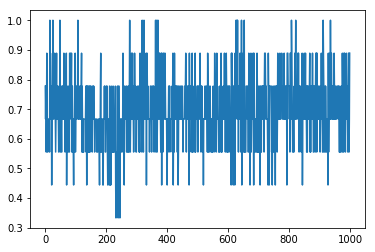

In [46]:
plt.plot(history)